In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime
import gzip
import matplotlib.gridspec as gridspec

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from methods.raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D

import methods.xflib as xflib

xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/WIPP_stencils/python/methods/libxformd.so')

R2D = 180./np.pi
D2R = np.pi/180.
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 18,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

In [96]:
infile = '../outputs/stencils/nightside/stencil_testing/phi_inlat_35_AE8MAX.pklz'

with gzip.open(infile,'rb') as file:
    data = pickle.load(file)

['phi_N_full', 'phi_S_sum', 'phi_N_sum', 'params', 'phi_S_full']
['E_tot_arr', 'Lshells', 'tvec', 'Emin', 'Emax', 'n_JL', 'NUM_E', 'E_EXP_TOP', 'fluxfile', 'E_EXP_BOT', 'flux_dist', 'dt', 'v_tot_arr', 'alpha_dist', 'n_JE', 'DE_EXP']
(4, 512, 1001)
2.5
(1000,) (512,)


<IPython.core.display.Javascript object>


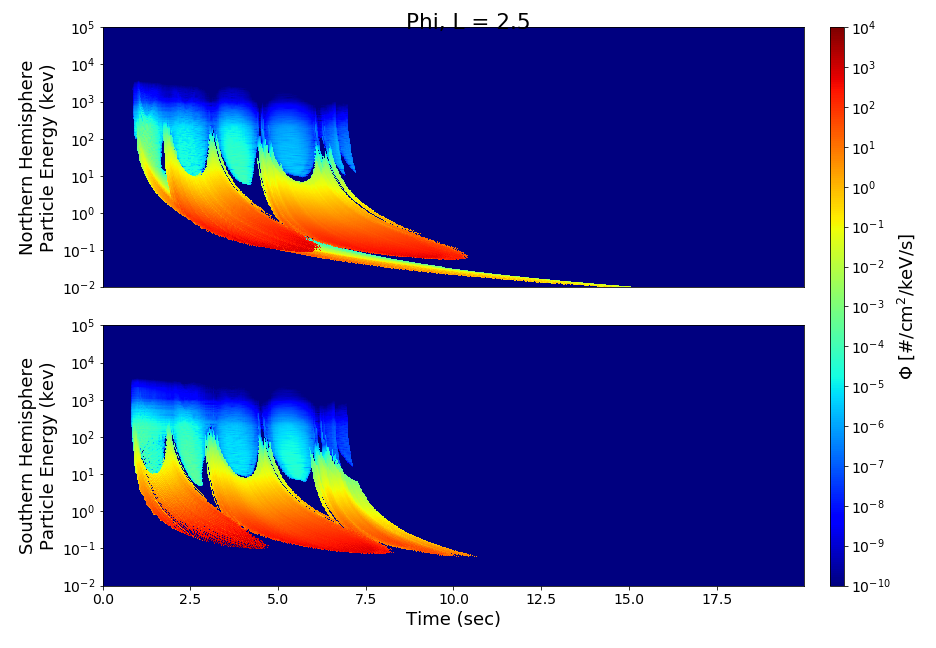

3.08098121591 -100.0


In [97]:
print data.keys()

ev2joule = (1.60217657)*1e-19 # Joules / ev
joule2millierg = 10*1e10 


# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 18,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------
# print data.keys()
phi_N = data['phi_N_full']
phi_S = data['phi_S_full']
Lshells = data['params']['Lshells']
tvec    = data['params']['tvec']
evec    = data['params']['E_tot_arr']

print data['params'].keys()
print np.shape(phi_N)
L_ind = 1
print Lshells[L_ind]

clims = [-10, 4]
print np.shape(tvec), np.shape(evec)

fig = plt.figure()
gs = gridspec.GridSpec(2,2, width_ratios=[1, 0.02])
print gs
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
cbax = plt.subplot(gs[:,-1])
cmap = plt.get_cmap('jet')


Ndata = np.log10(phi_N[L_ind,:,:-1])
Ndata[np.isinf(Ndata)] = -100
print np.max(Ndata), np.min(Ndata)
Sdata = np.log10(phi_S[L_ind,:,:-1])
Sdata[np.isinf(Sdata)] = -100
# print np.max(Sdata), np.min(Sdata)
p0 = ax0.pcolormesh(tvec, np.log10(evec/1000.), Ndata, vmin = clims[0], vmax=clims[1], cmap = cmap)
p1 = ax1.pcolormesh(tvec, np.log10(evec/1000.), Sdata, vmin = clims[0], vmax=clims[1], cmap = cmap)

ax0.set_xticks([])
ytix = ax0.get_yticks()
yticklabels = ['$10^{%d}$'%k for k in ytix]
ax0.set_yticklabels(yticklabels)
ytix = ax1.get_yticks()
yticklabels = ['$10^{%d}$'%k for k in ytix]
ax1.set_yticklabels(yticklabels)

ax0.set_ylabel('Northern Hemisphere\nParticle Energy (kev)')
ax1.set_ylabel('Southern Hemisphere\nParticle Energy (kev)')
ax1.set_xlabel('Time (sec)')

cb = plt.colorbar(p0, cax=cbax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('$\Delta \\alpha_{RMS}$ (deg)')
cb.set_label('$\Phi$ [#/cm$^2$/keV/s]')

fig.suptitle('Phi, L = %g'%Lshells[L_ind])
fig.tight_layout()

# ax[0].pcolormesh(Ndata, origin='lower',interpolation='none')



(4, 20, 512)
['E_tot_arr', 'Lshells', 'tvec', 'Emin', 'Emax', 'n_JL', 'NUM_E', 'E_EXP_TOP', 'fluxfile', 'E_EXP_BOT', 'flux_dist', 'dt', 'v_tot_arr', 'alpha_dist', 'n_JE', 'DE_EXP']


<IPython.core.display.Javascript object>


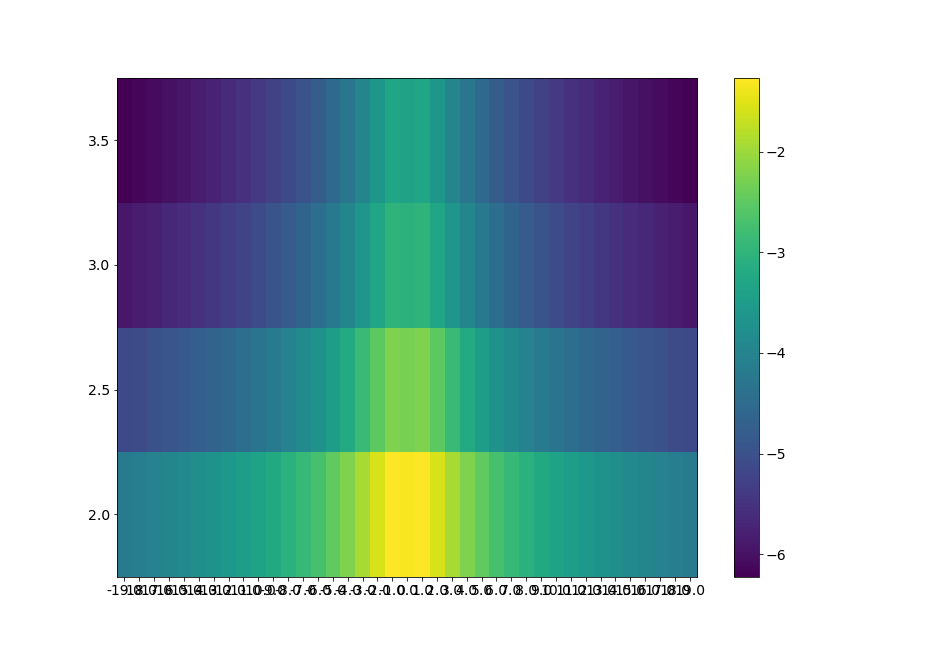

In [98]:
print np.shape(data['phi_N_sum'])

# Hotspot maps vs longitude and L-shell:

# First -- integrate phi to get N (number flux) or E

ev2joule = (1.60217657)*1e-19 # Joules / ev
joule2millierg = 10*1e10
# print data['params']['E_tot_arr']

print data['params'].keys()

# Energy vector, in ev
E = data['params']['E_tot_arr']
DE_EXP = data['params']['DE_EXP']
E_EXP_BOT = data['params']['E_EXP_BOT']
E_EXP_TOP = data['params']['E_EXP_TOP']
dt = data['params']['dt']

#  Energy differential term dE, in kev
DE = np.exp(np.linspace(1,len(E),len(E))*DE_EXP/np.log10(np.e))
DE = DE*DE_EXP/np.log10(np.e)
DE = DE*(1e-3)*np.power(10, E_EXP_BOT + DE_EXP/2.)

# Integrate over each energy bin
Q = data['phi_N_sum']*(E*DE)[np.newaxis,np.newaxis,:]*ev2joule*joule2millierg*dt
N = data['phi_N_sum']*(DE)[np.newaxis,np.newaxis,:]*dt

# Sum over energy bins
Ntotal = np.sum(N,axis=-1) # counts/cm^2, total for flash
Qtotal = np.sum(Q,axis=-1) # mErg/cm^2, total for flash

N_stencil = np.hstack([np.fliplr(Ntotal)[:,0:-1], Ntotal])
Q_stencil = np.hstack([np.fliplr(Qtotal)[:,0:-1], Qtotal])

num_lons = np.shape(Ntotal)[1]
dlon = 1
lon_max = num_lons - 1
lon_axis = np.linspace(-lon_max, lon_max, 2*num_lons - 1)
L_axis = data['params']['Lshells']
dl = 0.5
# Ntotal = Ntotal[:,-1:1]
# print np.shape(Ntotal)
# print Ntotal

fig, ax = plt.subplots(1,1)
# ax.imshow(np.hstack([np.fliplr(Ntotal)[:,0:-1], Ntotal]))
p = ax.pcolorfast(np.log10(Q_stencil))
plt.colorbar(p)

# Label the center of the bins
ax.set_xticks(np.arange(0,len(lon_axis)) + 0.5)
ax.set_xticklabels(lon_axis)

ax.set_yticks(np.arange(0,len(L_axis)) + 0.5)
ax.set_yticklabels(L_axis)
